In [1]:
%pip install opencv numpy pandas sklearn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


Importing all necessary dependencies : 

- cv2
- numpy
- pandas
- matplotlib

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

read all images and then append it in `images` list

In [3]:
plates = [
    'plates/019_jpg.rf.e73938ec62074bbde822f7d5a084bdef.jpg',
    'plates/BE9775U_png.rf.2ae51db435580876c898c833edd0f774.jpg',
    'plates/B3559SU_png.rf.da969620aaf4665b616f8f677a9a6201.jpg',
    'plates/B3326UB_png.rf.ae55e0c0bf99c732265edf021f844bf9.jpg',
    'plates/B2520XK_PNG.rf.4e22939a8917f509074397176d67c5e5.jpg',
]

images = []

for plate in plates:
    images.append(cv2.imread(plate))

`process_image` function takes image input and then extract the data like :

- `h` stand for height
- `w` stand for width
- `ch` stand for color space

and the after that we do a `normalization` to image by dividing it with 255, why? because This is a common technique in image processing to scale pixel values to the range `[0, 1]`. Since pixel values are typically in the range `[0, 255]`, dividing by `255.0` ensures that the normalized values are in the range `[0, 1]`.

The normalized image data is then reshaped into a two-dimensional array where each row corresponds to a pixel in the original image, and each column corresponds to a channel. This reshaping is done to convert the 3D array (representing an image with height, width, and channels) into a 2D array, which might be useful for certain types of processing or analysis.

In [4]:
# Define a function to process an image
def process_image(img):
    # Get image properties
    h, w, ch = img.shape

    # Normalize the image data
    data = img / 255.0

    # Reshape the data
    data = data.reshape(h * w, ch)

    return data

array([[0.12156863, 0.11764706, 0.1254902 ],
       [0.05490196, 0.05098039, 0.05882353],
       [0.18431373, 0.18039216, 0.18823529],
       ...,
       [0.35294118, 0.31764706, 0.2627451 ],
       [0.30980392, 0.2745098 , 0.21960784],
       [0.31764706, 0.27058824, 0.22352941]])

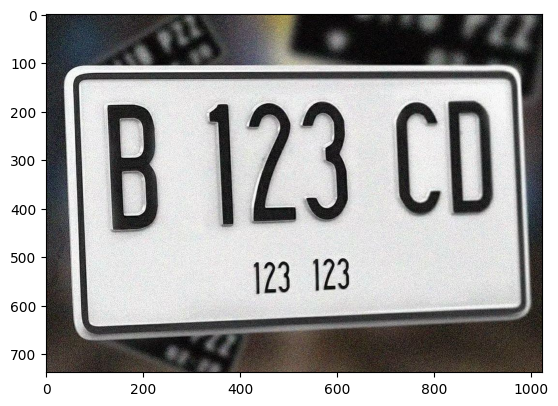

In [8]:
datas = []

for img in images:
    datas.append(process_image(img))

plt.imshow(images[0])
datas[0]

A random subset of N pixels is chosen from the input data using a random permutation. This is useful when dealing with a large dataset, as it allows for a manageable number of points in the scatter plot. The RGB values of the selected subset are extracted.

In [9]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)

In [10]:
def count_possible_colors(processed_data):
    # Reshape the data to a 2D array (pixels x channels)
    pixels = processed_data.reshape(-1, processed_data.shape[-1])

    # Get the number of possible colors (distinct color combinations)
    possible_colors = pixels.shape[0]

    return possible_colors

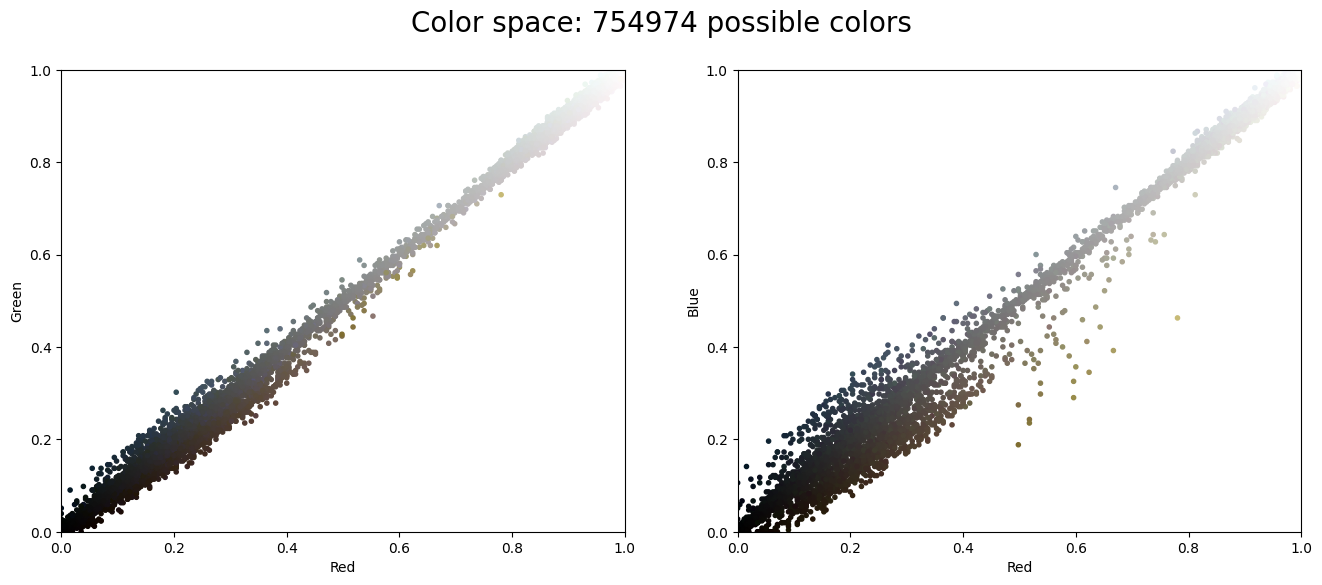

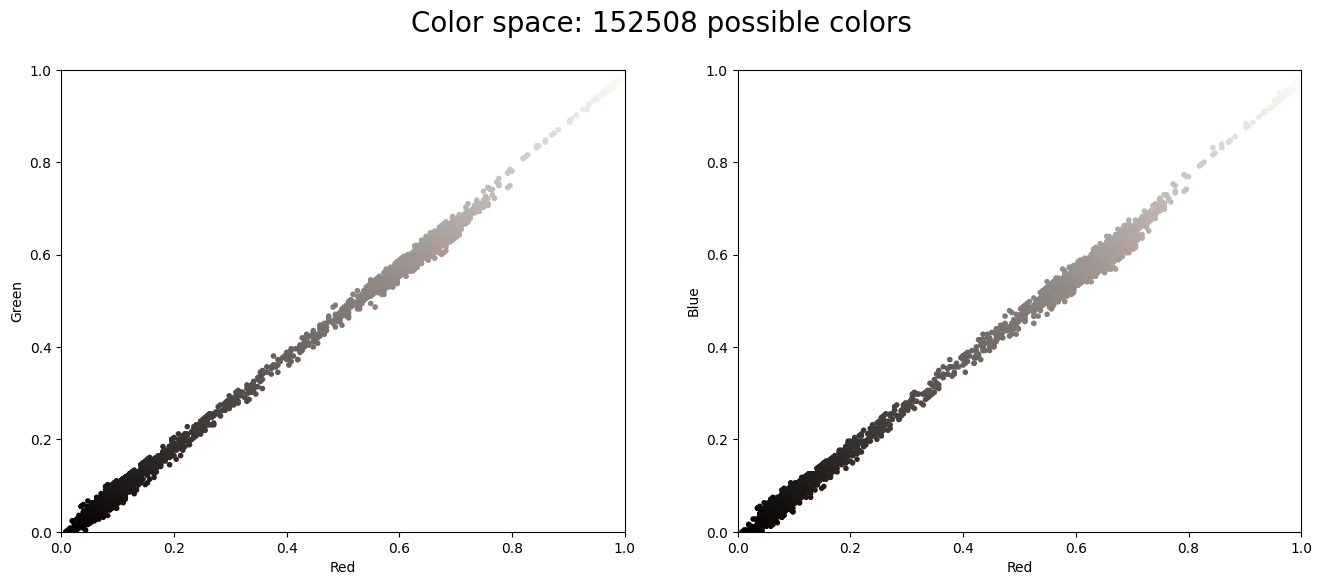

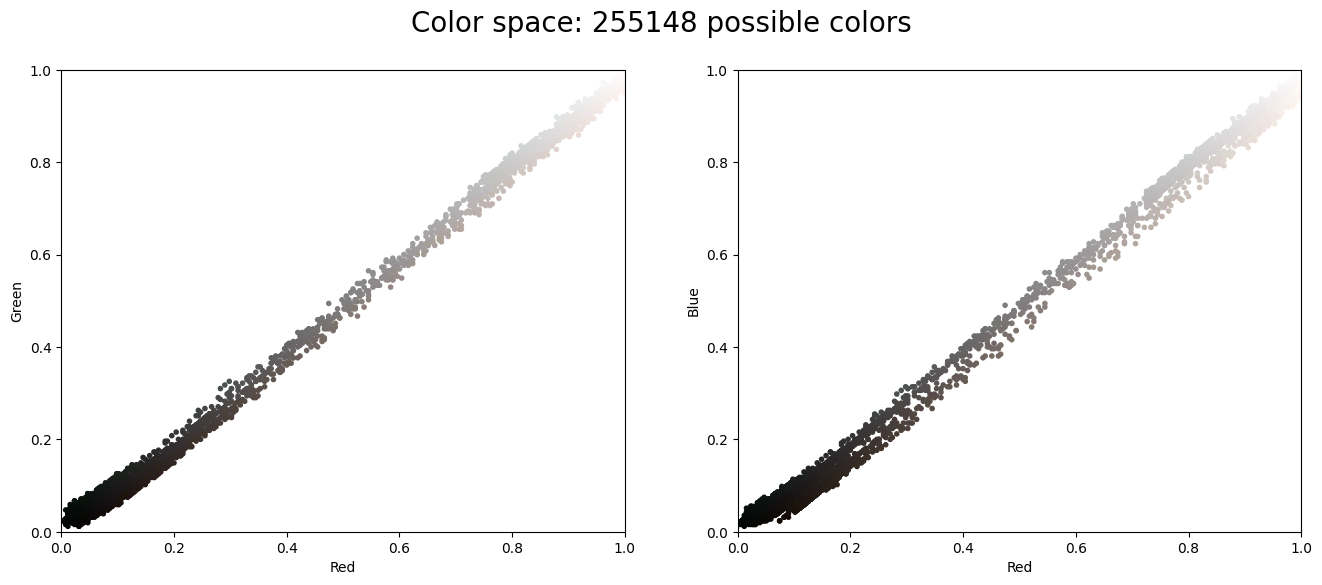

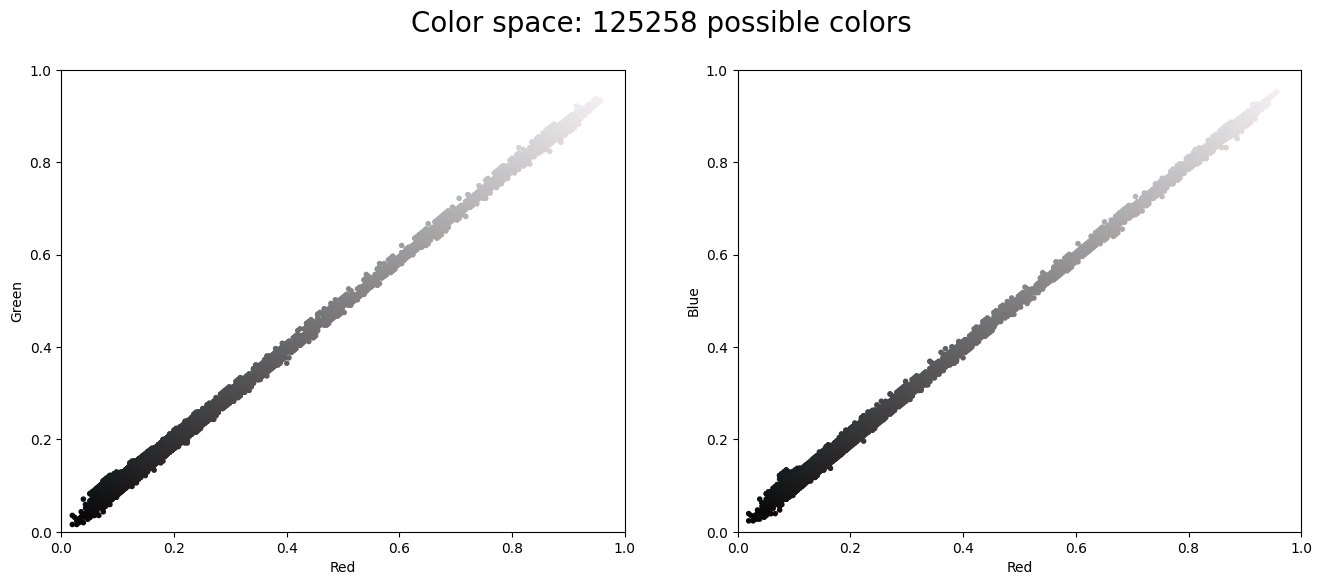

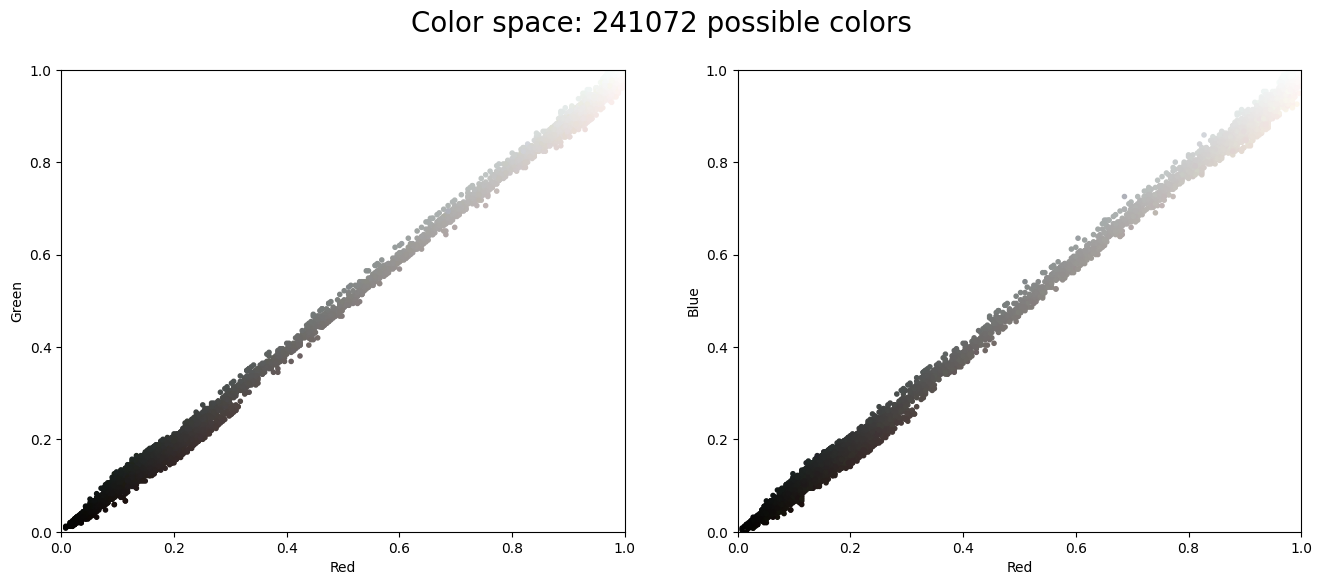

In [12]:
for data in datas:
    possible_color = count_possible_colors(data)
    plot_pixels(data, title=f'Color space: {possible_color} possible colors')

The reshape_pixel function reshapes the input image's pixel values into a 2D array where each row represents a pixel, and each column represents a color channel (assuming a three-channel color image). The -1 in the reshape function allows NumPy to automatically infer the size along that dimension based on the total number of elements. The pixel values are then converted to float32 for numerical processing.

In [13]:
processed_pixel_vals_list = []

def reshape_pixel(img):
    # Reshape and convert pixel values to float32
    pixel_vals = img.reshape((-1, 3))
    pixel_vals = np.float32(pixel_vals)

    # Append the processed pixel values to the list
    processed_pixel_vals_list.append(pixel_vals)

In [15]:
for img in images:
    reshape_pixel(img)

processed_pixel_vals_list[0]

array([[31., 30., 32.],
       [14., 13., 15.],
       [47., 46., 48.],
       ...,
       [90., 81., 67.],
       [79., 70., 56.],
       [81., 69., 57.]], dtype=float32)

`criteria`: This variable sets the criteria for the k-means algorithm. It uses the combination of two termination criteria: `cv2.TERM_CRITERIA_EPS` (terminate when the specified accuracy is reached) and `cv2.TERM_CRITERIA_MAX_ITER` (terminate after the specified number of iterations). The 100 is the maximum number of iterations, and 0.85 is the required accuracy.

`k`: This variable represents the number of clusters in the k-means algorithm. In other words, it determines how many dominant colors the algorithm will try to identify in the images.

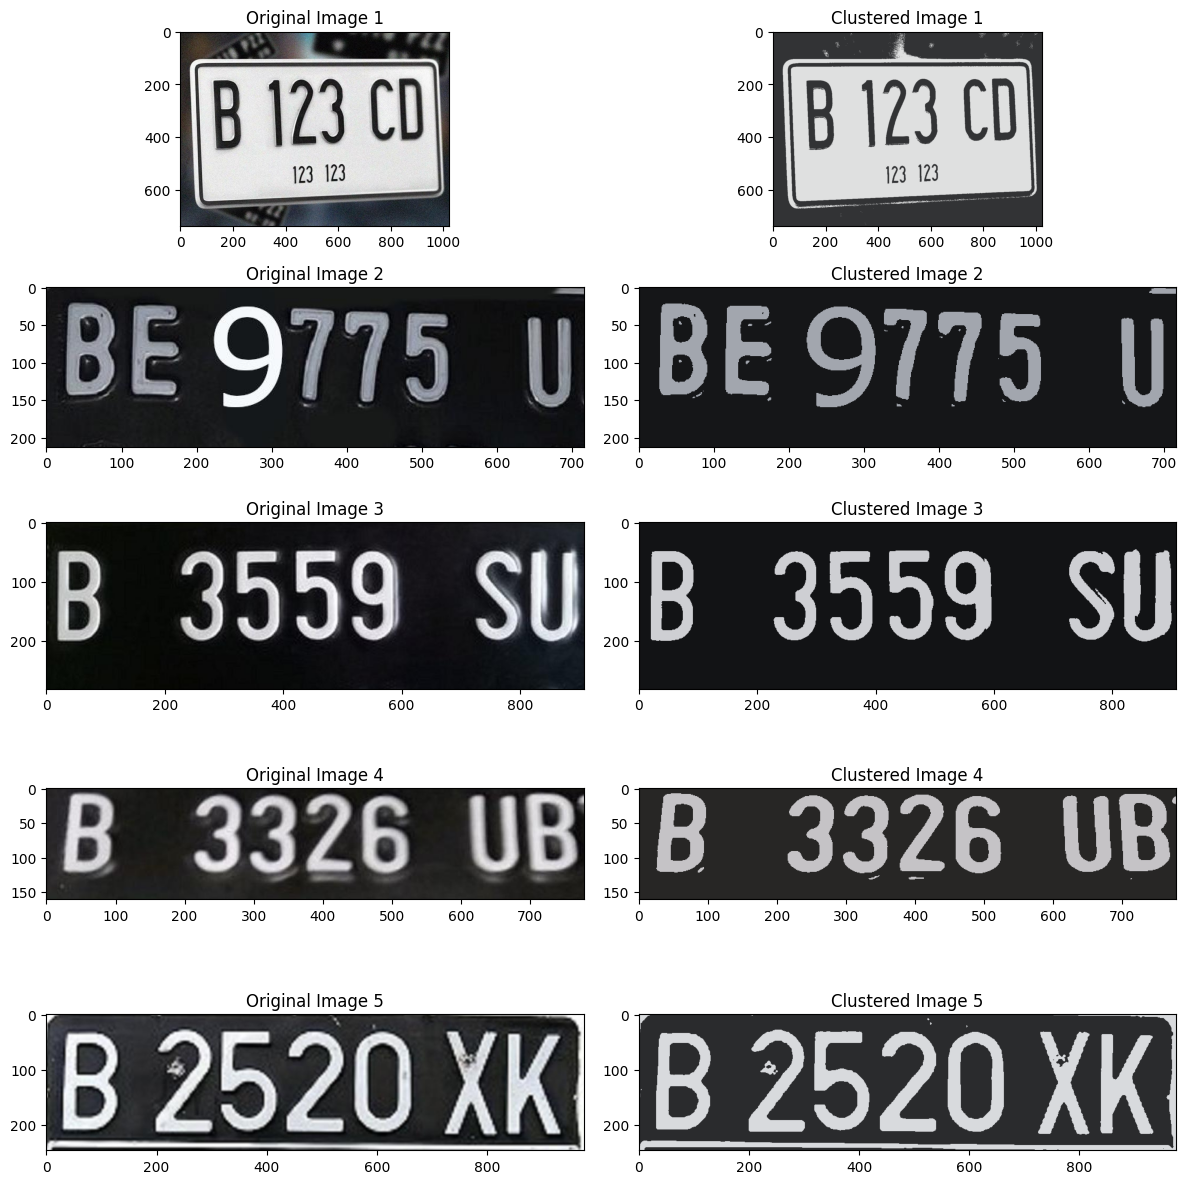

In [22]:
# K-means clustering parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.9)
k = 2 # how much cluster, how much dominant color

# Create a list to store clustered images
clustered_images = []

# Create a figure to display all images
plt.figure(figsize=(12, 12))

# Ensure that 'i' is within the valid range
for i, pixel_vals in enumerate(processed_pixel_vals_list):
    if i < len(images):
        # Perform k-means clustering
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert data into 8-bit values
        centers = np.uint8(centers)
        segmented_data = centers[labels.flatten()]

        # Reshape data into the original image dimensions
        segmented_image = segmented_data.reshape((images[i].shape))
        clustered_images.append(segmented_image)

        # Display the original and clustered images in subplots
        plt.subplot(5, 2, 2 * i + 1)  # 5 rows, 2 columns
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Original Image {i + 1}')

        plt.subplot(5, 2, 2 * i + 2)  # 5 rows, 2 columns
        plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Clustered Image {i + 1}')

plt.tight_layout()
plt.show()

In the context of OCR (Optical Character Recognition), the goal is typically to extract text information from images. K-means clustering is not a typical preprocessing step for OCR, and its use might depend on the specific requirements and characteristics of the images you are working with.

The primary purpose of k-means clustering is to identify dominant colors or color clusters in an image. It can be useful for image segmentation tasks where you want to group pixels with similar colors together. This can be applied in applications like image compression, color quantization, or certain types of image analysis.

For OCR, the preprocessing steps usually involve techniques that enhance text visibility and reduce noise, rather than clustering colors. Common preprocessing steps for OCR include:

Grayscale Conversion: Convert the image to grayscale, which simplifies the image and reduces the amount of information to process.

Thresholding: Apply thresholding techniques to separate text from the background and enhance the contrast.

Noise Reduction: Use techniques like blurring or morphological operations to reduce noise and smooth the image.

Binarization: Convert the image to binary (black and white) to make it easier to identify text regions.

Text Region Detection: Identify regions of interest that likely contain text.

K-means clustering might be relevant if your images have specific characteristics where color information plays a crucial role in separating text from the background. However, for most OCR scenarios, focusing on traditional preprocessing techniques like those mentioned above is more common.

If you have specific details about your images or if there are particular challenges you're facing in your OCR task, please provide more information, and I can offer more targeted advice.